In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
plt.rcParams['font.size'] = 14

# manifold.TSNE
from sklearn import manifold  #, datasets
from time import time
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import DBSCAN
#from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict


N= 1000   D= 3
1552.6302096770091
mean minimum distance between points:  18.55757910124019


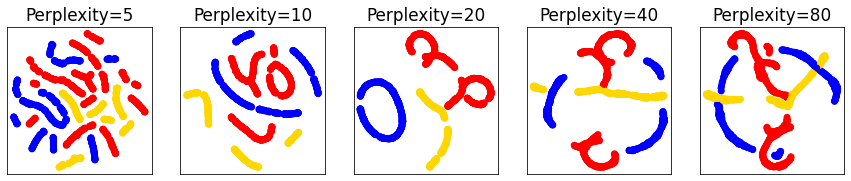

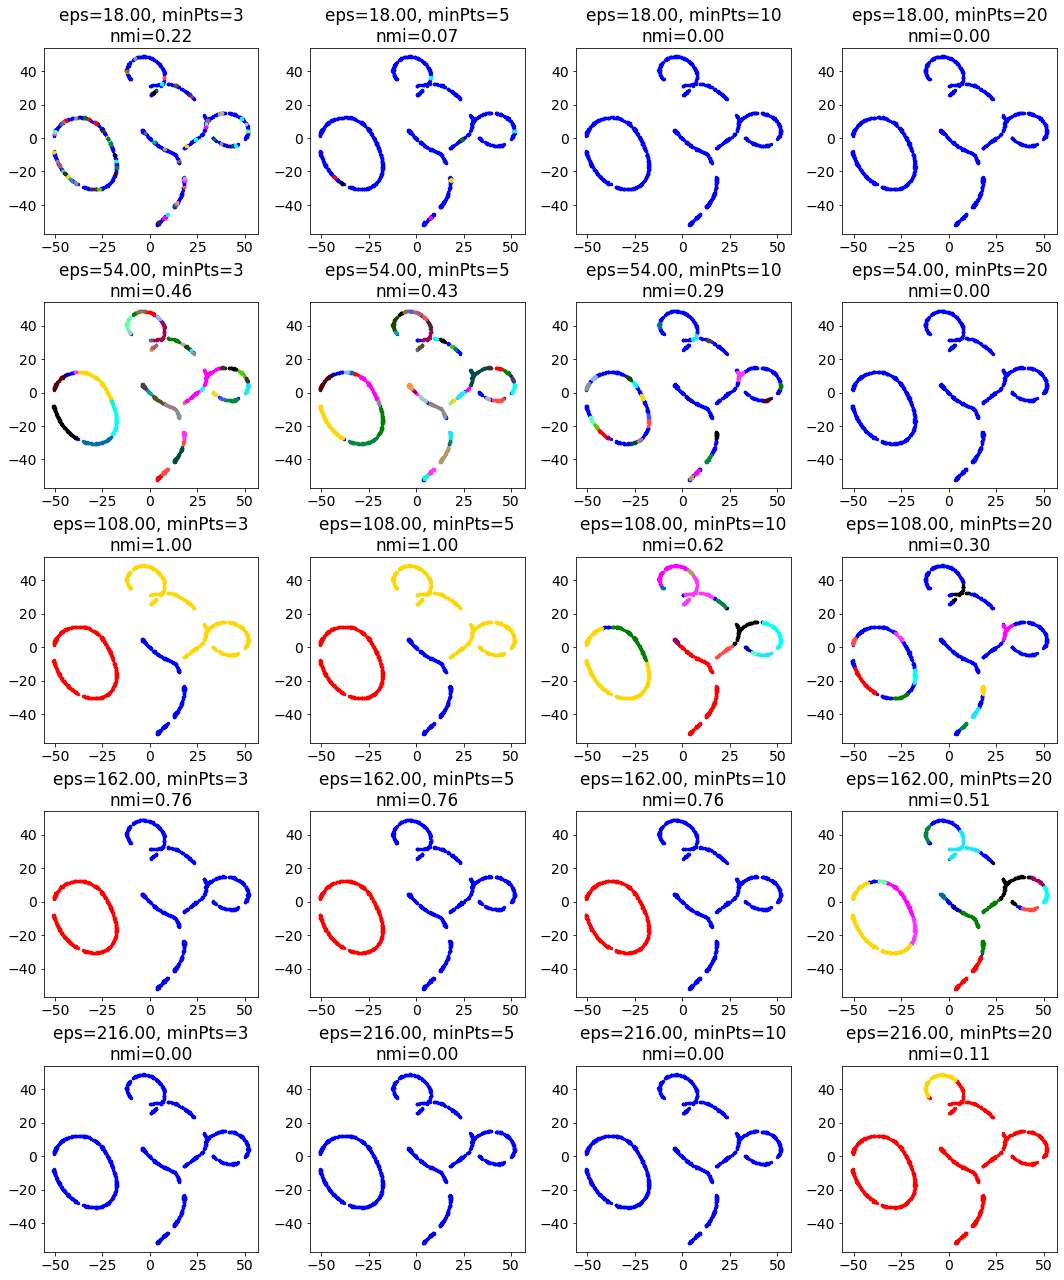

N= 1000   D= 4
1268.4839912157263
mean minimum distance between points:  21.767814126488283


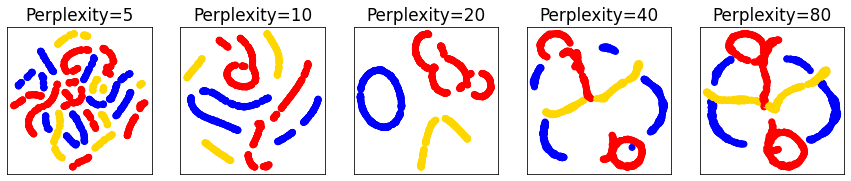

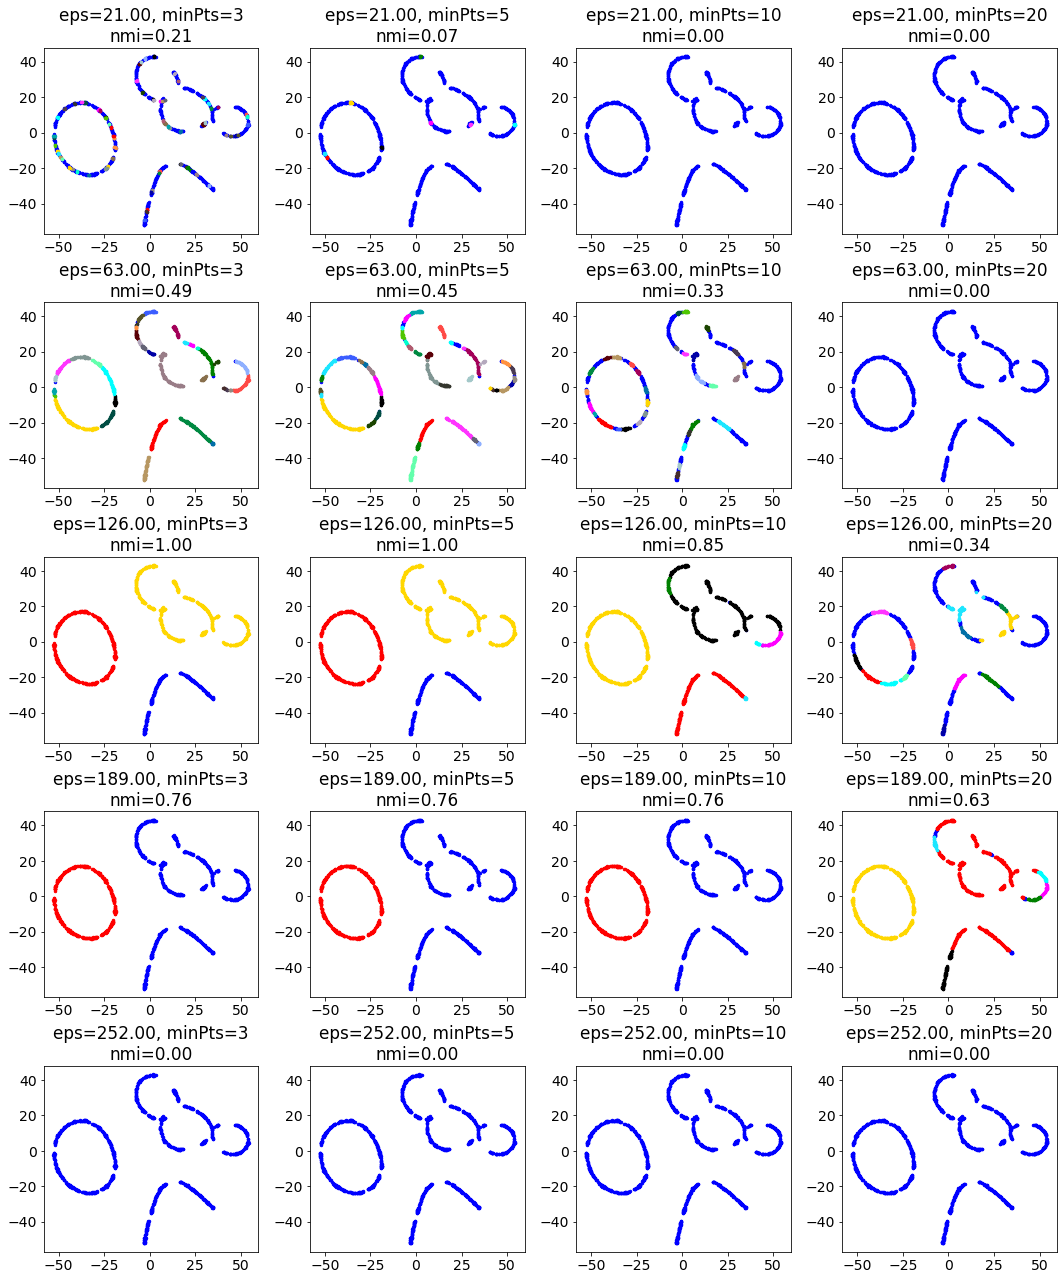

N= 1000   D= 5
155.801916228552
mean minimum distance between points:  25.10928460306187


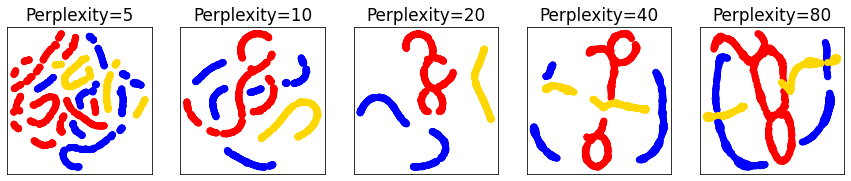

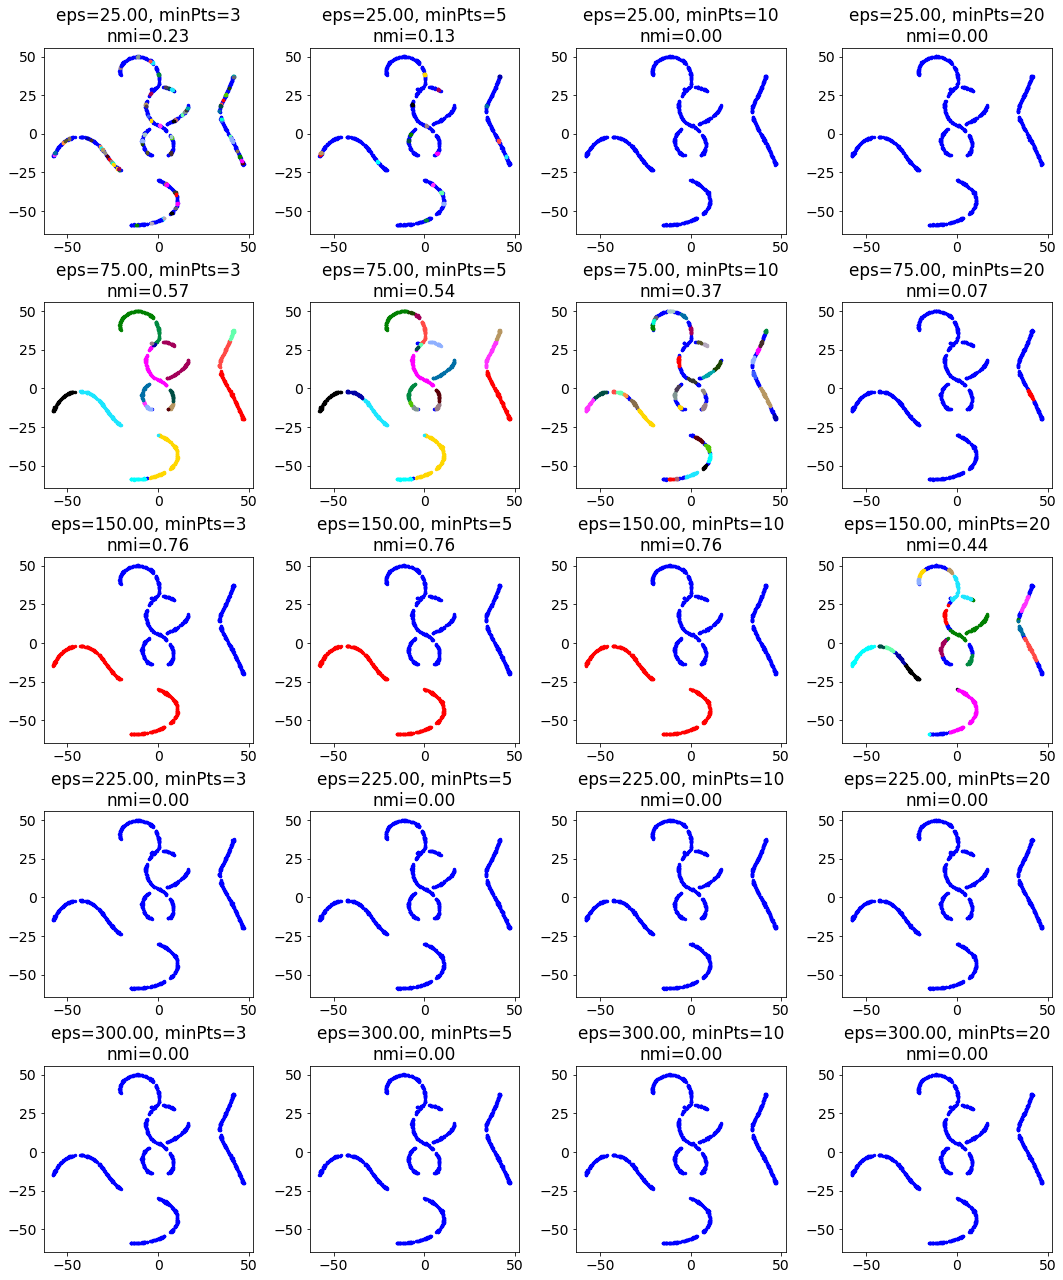

N= 1000   D= 6
442.8079825982407
mean minimum distance between points:  28.459601384708932


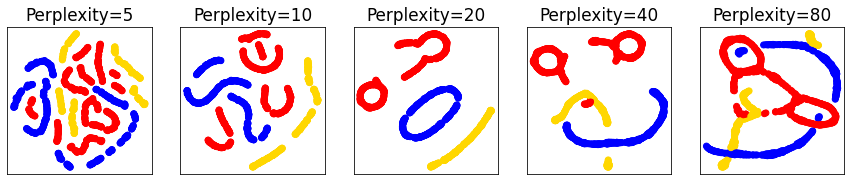

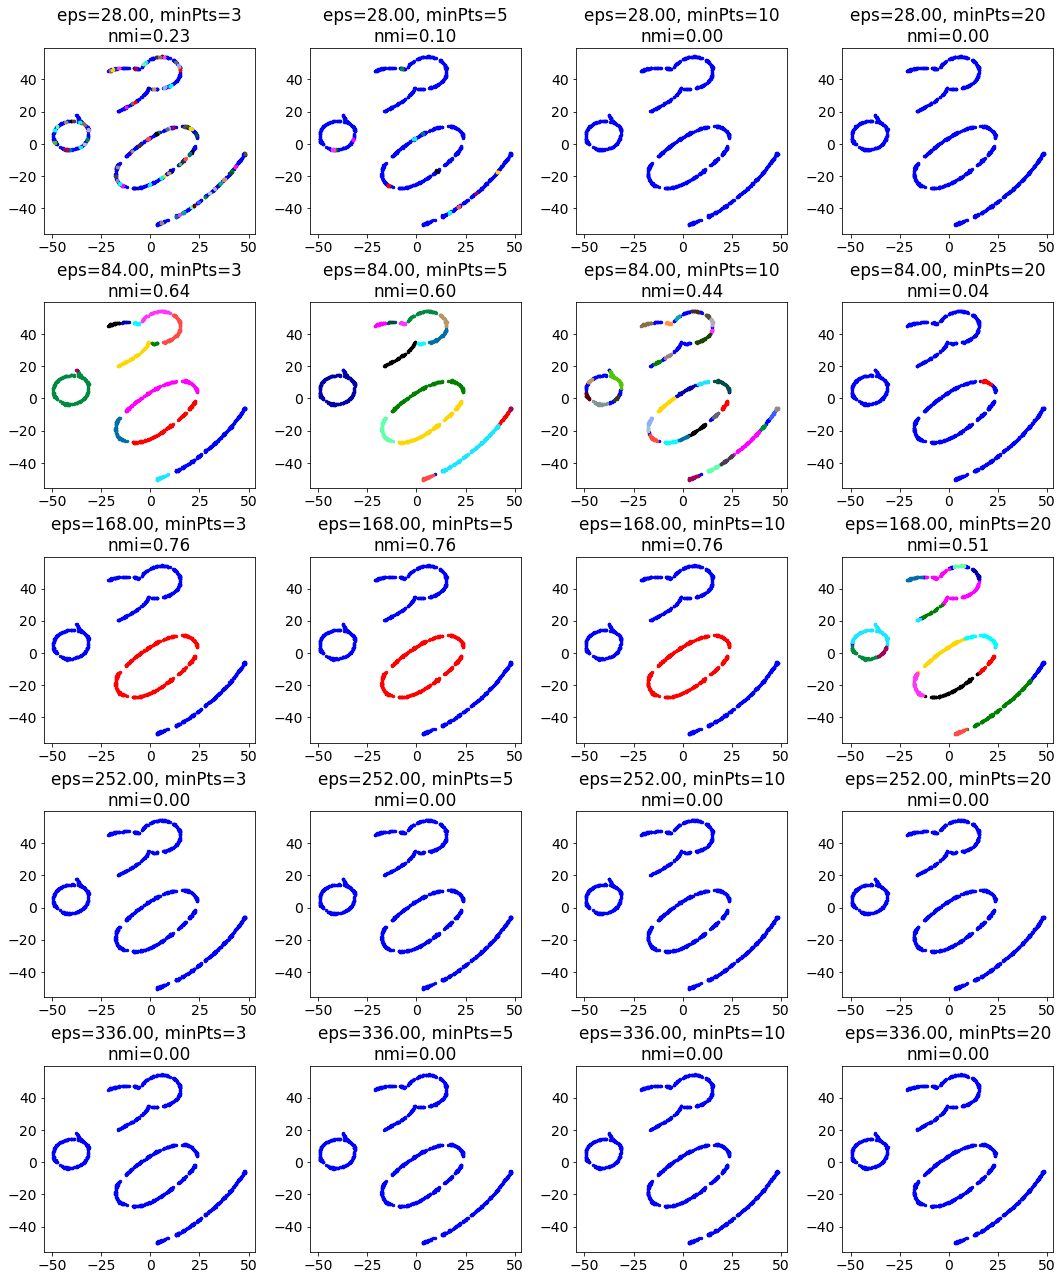

N= 1000   D= 8
1058.8827494367163
mean minimum distance between points:  33.673297183034606


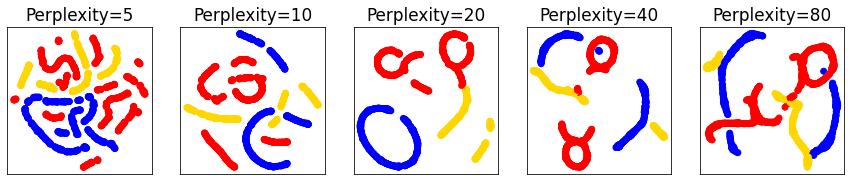

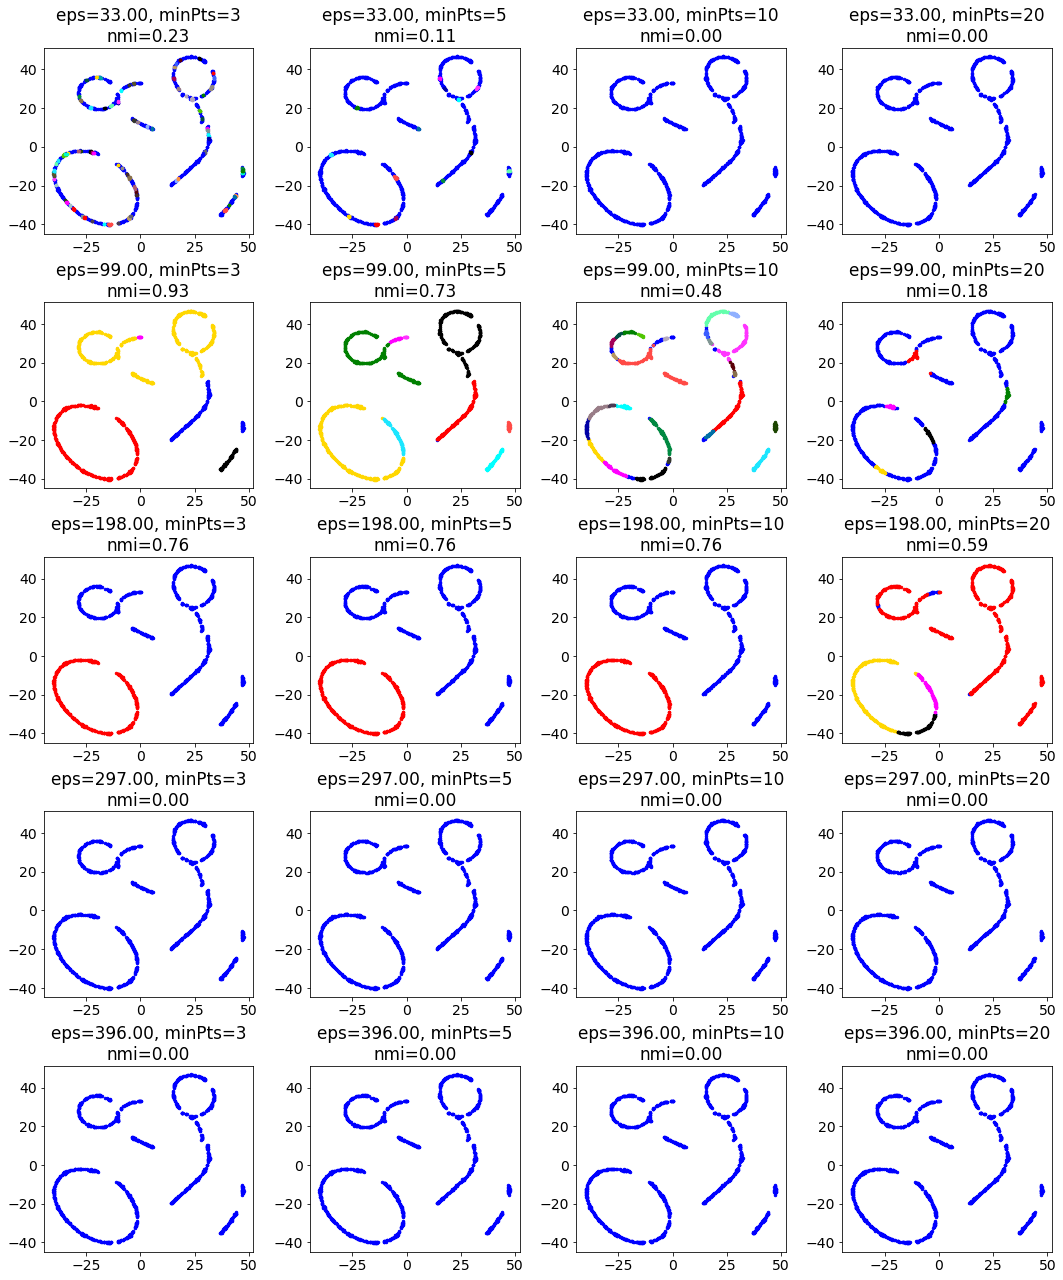

N= 1000   D= 12
1604.7100755072854
mean minimum distance between points:  42.27703188897607


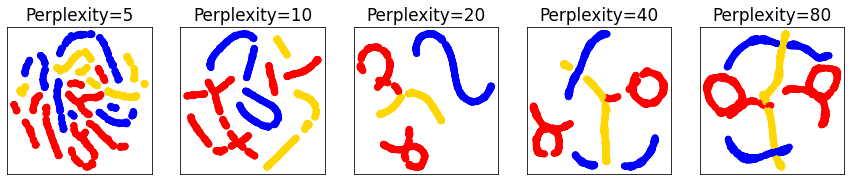

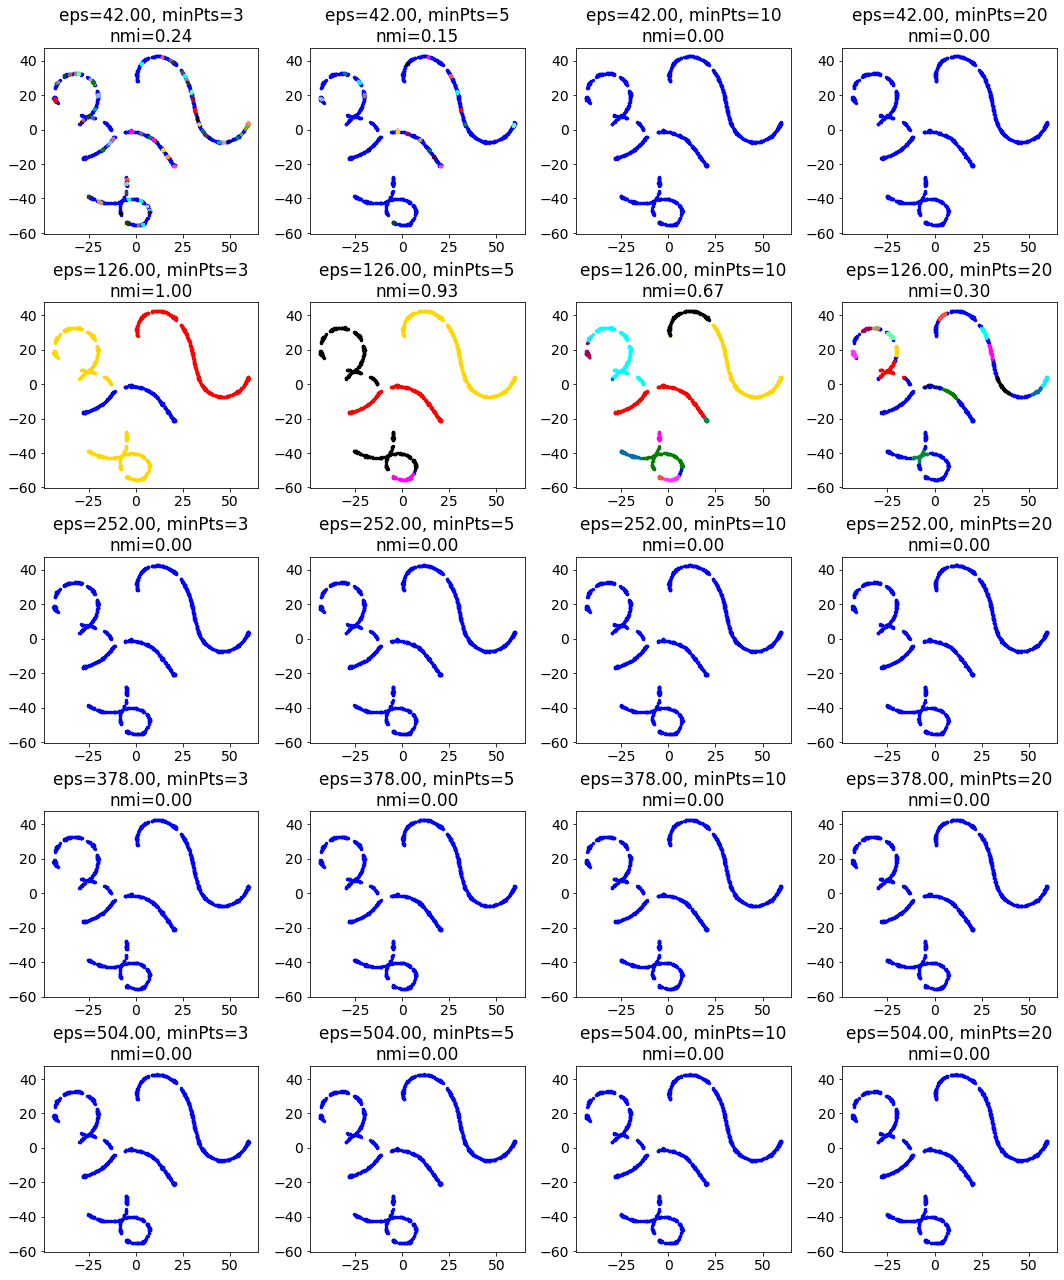

N= 1000   D= 15
1547.0262966616076
mean minimum distance between points:  48.06310202850656


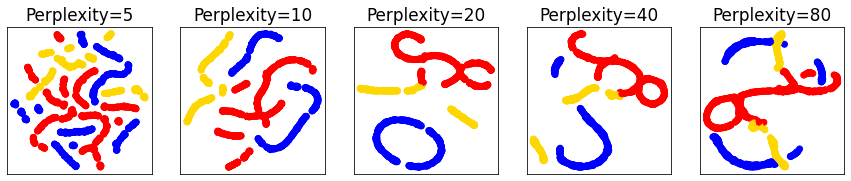

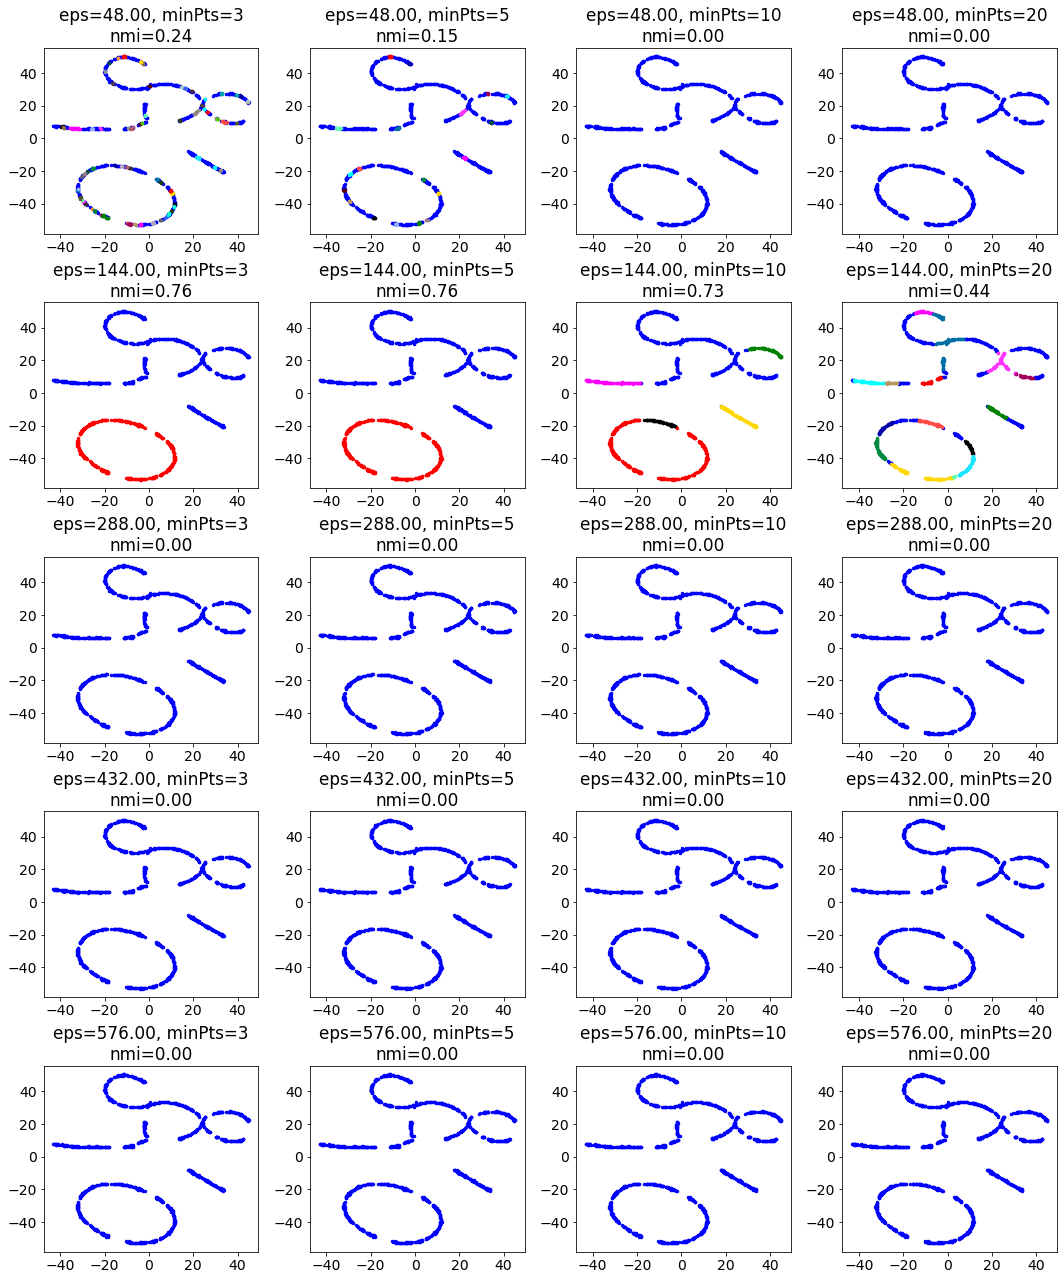

In [4]:
def dist(x,i,j):
    return np.linalg.norm(x[i]-x[j])

cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]
ms = 6

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)
        
for k in [3,4,5,6,8,12,15]:
    
    fname,fnamey=f"x_{k}d.dat",f"y_{k}d.dat"
    data=np.loadtxt("DATA/"+fname, delimiter='\t')
    y=np.loadtxt("DATA/"+fnamey,dtype=int)
    N=len(data)
    D=len(data[0])
    print("N=",N,"  D=",D)
    x=data

    print(dist(x,13,1))
    mdist = np.zeros(N)
    for i in range(N):
        dm = 1e100
        for j in range(N):
            if i!=j:
                dij = dist(x,i,j);
                if dij<dm:
                    dm = dij
        mdist[i] = dm
    mean_min_dist = mdist.mean()
    print("mean minimum distance between points: ",mean_min_dist)
    
    np.random.seed(0)
    n_samples = N
    n_components = 2 
    perplexities = [5, 10, 20, 40, 80]
    Np = len(perplexities)
    mycmap = ListedColormap(["blue","red","gold" ])

    (fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

    X_all = [None]
    for i, perplexity in enumerate(perplexities):
        ax = subplots[i]

        t0 = time()
        tsne = manifold.TSNE(n_components=n_components, init='random',
                             random_state=0, perplexity=perplexity)
        Y = tsne.fit_transform(data)
        t1 = time()
        ax.set_title("Perplexity=%d" % perplexity)
        ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
        ax.tick_params(left=False,bottom=False)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.axis('tight')
        X_all.append(Y)
    plt.savefig(f"tsne{k}.png")
    plt.show()
    # DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
    np.random.seed(12345)
    n_true_center=3
    #X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
    X2D = X_all[3] # best visualization above
    X = data
    y_true = y

    #eps_range = [0.01,0.1,0.5,1.0,10.]
    if mean_min_dist<10:
        r=mean_min_dist
    else:
        r = int(mean_min_dist)
    eps_range = [r,3*r,6*r,9*r,12*r]
    min_sample_range = [3,5,10,20]
    fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,18))
    for i, eps in enumerate(eps_range):
        for j, min_samples in enumerate(min_sample_range):
            model = DBSCAN(eps=eps, min_samples=min_samples)
            model.fit(X)
            y_hat = model.labels_
            plotting_ax(X2D,y_hat,ax[i,j])
            nmi=NMI(y_hat, y_true)
            ax[i,j].set_title('eps=%.2f, minPts=%i\nnmi=%.2f'%(eps,min_samples,nmi))
    plt.tight_layout(h_pad=0.5)
    plt.savefig(f"result{k}.png")
    plt.show()

